# Kevitsa VTEM 

In [1]:
from SimPEG import Mesh, EM, Utils, Maps
from matplotlib.colors import LogNorm
%pylab inline
import numpy as np
from scipy.constants import mu_0
from ipywidgets import interact, IntSlider
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
url = "https://storage.googleapis.com/simpeg/kevitsa_synthetic/"
files = ['dc_mesh.txt', 'dc_sigma.txt']
keys = ['mesh', 'sigma']
downloads = Utils.download([url + f for f in files], folder='./KevitsaDC', overwrite=True)
downloads = dict(zip(keys, downloads))

overwriting /Users/sgkang/Downloads/KevitsaDC/dc_mesh.txt
overwriting /Users/sgkang/Downloads/KevitsaDC/dc_sigma.txt
   saved to: /Users/sgkang/Downloads/KevitsaDC/dc_mesh.txt
   saved to: /Users/sgkang/Downloads/KevitsaDC/dc_sigma.txt
Download completed!


## Model

This model is a synthetic based on geologic surfaces interpreted from seismic data over the Kevitsa deposit in Finland. Synthetic 3D conductivity model is generated, and below figure shows conductivity section acrosses the mineralzined zone of interest. Nearsurface conductor on the lefthand side corresponds to sedimentary unit, and embedded conductor on the righthand side indicates conductive mineralized zone. Our interest here is in conductive mineralized zone at depth. 

/Users/sgkang/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


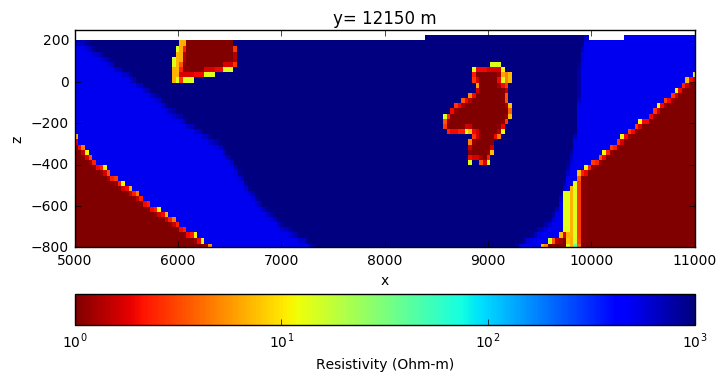

In [4]:
mesh3D = Mesh.TensorMesh.readUBC(downloads["mesh"])
sigmadc = mesh3D.readModelUBC(downloads["sigma"])
actind = ~np.isnan(sigmadc)
figsize(8, 4)
indy = 6
temp = 1./sigmadc.copy()
temp[~actind] = np.nan
out = mesh3D.plotSlice(temp, normal="Y", ind=indy, pcolorOpts={"norm": LogNorm(), "cmap":"jet_r"}, clim=(1e0, 1e3))
plt.ylim(-800, 250)
plt.xlim(5000, 11000)
plt.gca().set_aspect(2.)
plt.title(("y= %d m")%(mesh3D.vectorCCy[indy]))
cb = plt.colorbar(out[0], orientation="horizontal")
cb.set_label("Resistivity (Ohm-m)")

## Question: 

Can we see mineralized zone at depth (~200 m) using airborne EM?
To answer this question, we simplify our model as a) conductive layer and b) conductive cylinder embedded at depth. 

## Mesh

We use symmetric cylindrical mesh to simulate airborne time domain EM with this simplied model. Below code show how you design mesh. 

In [5]:
sig_halfspace = 2e-3
sig_target = 0.1
sig_air = 1e-8
times = np.logspace(-4, -2, 21)
def diffusion_distance(sigma, time):
    return 1.28*np.sqrt(time/(sigma * mu_0))

print(
    'min diffusion distance: {:.2e} m'.format(diffusion_distance(sig_halfspace, times.min()))
)
print(
    'max diffusion distance: {:.2e} m'.format(diffusion_distance(sig_halfspace, times.max()))
)

# x-direction
csx = 20  # core mesh cell width in the x-direction
ncx = 20
npadx = 15  # number of x padding cells

# z-direction
csz = 20  # core mesh cell width in the z-direction
ncz = 40
npadz = 15  # number of z padding cells

# padding factor (expand cells to infinity)
pf = 1.3

# cell spacings in the x and z directions
hx = Utils.meshTensor([(csx, ncx), (csx, npadx, pf)])
hz = Utils.meshTensor([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# define a SimPEG mesh
mesh = Mesh.CylMesh([hx, 1, hz], x0 ="00C")

min diffusion distance: 2.55e+02 m
max diffusion distance: 2.55e+03 m


The maximum diffusion distance (in background) is: 2.55e+03 m. Does the mesh go sufficiently past that?


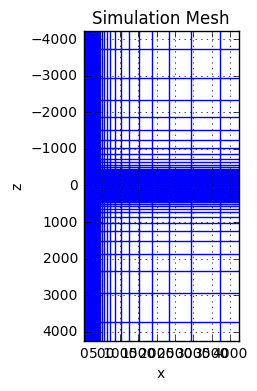

In [6]:
# X and Z limits we want to plot to. Try 
xlim = np.r_[0., mesh.vectorCCx.max()]
zlim = np.r_[mesh.vectorCCz.max(), mesh.vectorCCz.min()]

fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

ax.set_title('Simulation Mesh')
ax.set_xlim(xlim)
ax.set_ylim(zlim)

print(
    'The maximum diffusion distance (in background) is: {:.2e} m. '
    'Does the mesh go sufficiently past that?'.format(
        diffusion_distance(sig_halfspace, times.max())
    )
)
ax.set_aspect("equal")

Next, we put the model on the mesh

In [7]:
# create a vector that has one entry for every cell center
sigma = sig_air*np.ones(mesh.nC)  # start by defining the conductivity of the air everwhere
sigma[mesh.gridCC[:,2] < 0.] = sig_halfspace  # assign halfspace cells below the earth
sigma_background = sigma.copy()
sigma_layer = sigma.copy()
radius = 150.
# indices of the sphere (where (x-x0)**2 + (z-z0)**2 <= R**2)
layer_ind = np.logical_and(mesh.gridCC[:,2]>-300, mesh.gridCC[:,2]<-200)
blk_ind = (mesh.gridCC[:,0] < radius) & layer_ind
sigma[blk_ind] = sig_target  # assign the conductivity of the sphere
sigma_layer[layer_ind] = sig_target  # assign the conductivity of the sphere

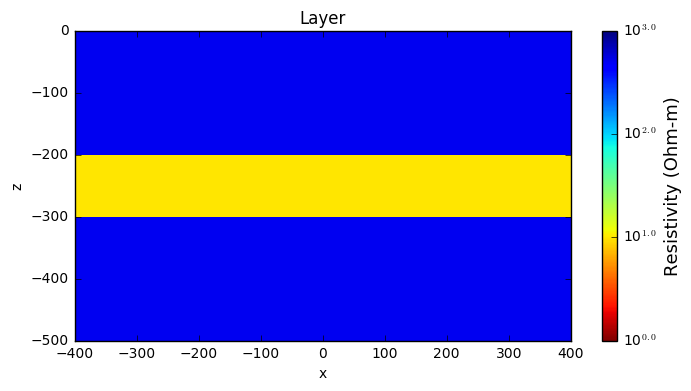

In [8]:
plt.set_cmap(plt.get_cmap('jet_r'))
# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,1)
out = mesh.plotImage(np.log10(1./sigma_layer), ax=ax, mirror=True, clim=(0, 3), grid=False)
cb = plt.colorbar(out[0], ticks=np.linspace(0,3,4), format="10$^{%.1f}$")
# plot formatting and titles
cb.set_label('Resistivity (Ohm-m)', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-500., 0.])
ax.set_title('Layer')

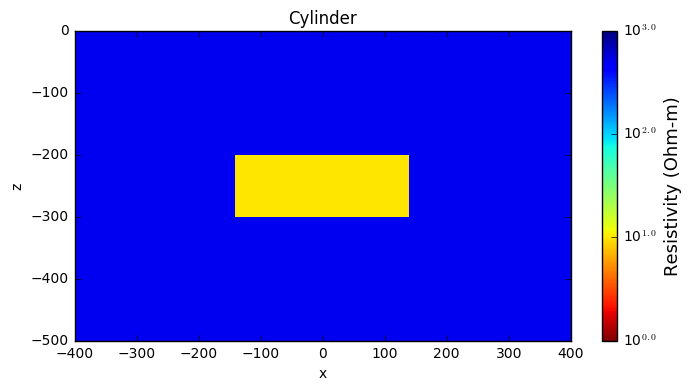

In [9]:
# Plot a cross section of the conductivity model
fig, ax = plt.subplots(1,1)
out = mesh.plotImage(np.log10(1./sigma), ax=ax, mirror=True, clim=(0, 3), grid=False)
# plot formatting and titles
cb = plt.colorbar(out[0], ticks=np.linspace(0,3,4), format="10$^{%.1f}$")
# plot formatting and titles
cb.set_label('Resistivity (Ohm-m)', fontsize=13)
ax.axis('equal')
ax.set_xlim([-120., 120.])
ax.set_ylim([-500., 0.])
ax.set_title('Cylinder')

## Forward Simulation 

Define source and receiver loop location, and put parameters of the waveform. Here we use a current loop source having 13m-radius and measure db/dt in vertical direction inside of the loop. Both loops are located 41m above the surface. 

In [10]:
rx_loc = np.array([[0., 0., 41.]])
src_loc = np.array([[0., 0., 41.]])
offTime = 0.007307
peakTime = 0.006
a = 3.
dbdt_z = EM.TDEM.Rx.Point_dbdt(locs=rx_loc, times=times+offTime, orientation='z')  # vertical db_dt
rxList = [dbdt_z]  # list of receivers
srcList = [
    EM.TDEM.Src.CircularLoop(
        rxList, loc=src_loc, radius=13., orientation='z', waveform=EM.TDEM.Src.VTEMWaveform(offTime=offTime, peakTime=peakTime, a=3.)
    )
]

In [11]:
# solve the problem at these times
timeSteps = [(peakTime/5, 5), ((offTime-peakTime)/5, 5), (1e-5, 10), (5e-5, 10), (1e-4, 10), (5e-4, 19)] 
prob = EM.TDEM.Problem3D_b(mesh, timeSteps = timeSteps, sigmaMap=Maps.IdentityMap(mesh))  
survey = EM.TDEM.Survey(srcList)
prob.pair(survey)  

In [12]:
src = srcList[0]
rx = src.rxList[0]
wave = []
for time in prob.times:
    wave.append(src.waveform.eval(time))
wave = np.hstack(wave)

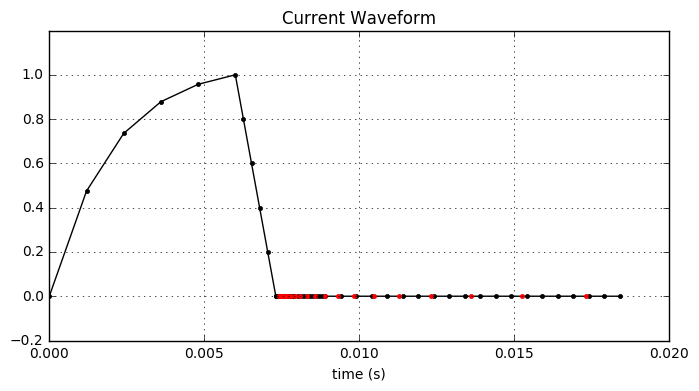

In [13]:
plt.plot(prob.times, wave, 'k.-')
plt.plot(rx.times, np.zeros_like(rx.times), 'r.')
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.title('Current Waveform')
plt.xlabel('time (s)')

## Compute Predicted Data

We compute three different data: a) background (halfspace), b) layer, and d) cylinder models. 

In [14]:
d_background = survey.dpred(sigma_background)
d_layer = survey.dpred(sigma_layer)
d = survey.dpred(sigma)

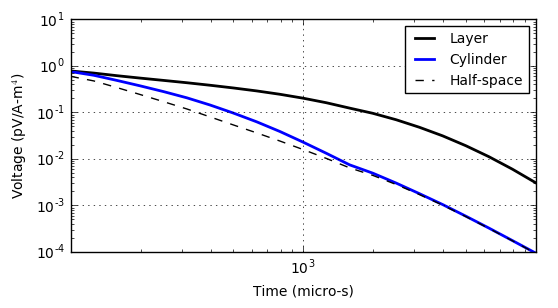

In [15]:
area = 13**2*np.pi 
figsize(6, 3)
plt.loglog((rx.times-offTime)*1e6, -d_layer*1e12/area, 'k', lw=2)
plt.loglog((rx.times-offTime)*1e6, -d*1e12/area , 'b', lw=2)
plt.loglog((rx.times-offTime)*1e6, -d_background*1e12/area, 'k--', lw=1)

plt.xlabel("Time (micro-s)")
plt.ylabel("Voltage (pV/A-m$^4$)")
plt.legend(("Layer", "Cylinder","Half-space"), loc=1, fontsize = 10)
plt.ylim(1e-4, 1e1)
plt.grid(True)

### Question:

What was your thoughts on the above plot? Can we see conductive mineralzied zone?
Singals from Layer and Cylinder have significant difference, can you explain why? 

Underlying physics of the measured voltage can be govered by Faraday's law:

$$ \nabla \times \vec{e} - \frac{d\vec{b}}{dt}$$

By showing how electric field propagates in the subsurface we illustrate why layer and cylinder model show significant difference. 

### Electric field in the layer model

In [16]:
f_layer = prob.fields(sigma_layer)

In [17]:
plt.set_cmap(plt.get_cmap('viridis'))
def vizfield_layer(itime):
    fig = plt.figure(figsize = (7*0.8,5*0.8))
    ax = plt.subplot(111)
    cb = plt.colorbar(mesh.plotImage(mesh.aveE2CC*f_layer[src, 'e', itime], ax=ax, mirror=True)[0])
    # plot formatting and titles
    cb.set_label('e$_{y}$ (V/m)', fontsize=13)
    ax.axis('equal')
    ax.set_xlim([-300., 300.])
    ax.set_ylim([-500., 0.])
    ax.set_title(('|e$_{y}$| at %d micro-s')%(prob.times[itime]*1e6))
    plt.show()
interact(vizfield_layer, itime=IntSlider(min=0, max=len(prob.times)-1, step=1, value=11))

<function __main__.vizfield_layer>

### Electric Field in the Cylinder model

In [18]:
f = prob.fields(sigma)

In [19]:
def vizfield_cylinder(itime):
    fig = plt.figure(figsize = (7*0.8,5*0.8))
    ax = plt.subplot(111)
    cb = plt.colorbar(mesh.plotImage(mesh.aveE2CC*f[src, 'e', itime], ax=ax, mirror=True)[0])
    # plot formatting and titles
    cb.set_label('e$_{y}$ (V/m)', fontsize=13)
#     ax.axis('equal')
    ax.set_xlim([-300., 300.])
    ax.set_ylim([-500., 0.])
    ax.set_title(('|e$_{y}$| at %d micro-s')%(prob.times[itime]*1e6))
    plt.tight_layout()
    plt.show()
interact(vizfield_cylinder, itime=IntSlider(min=0, max=len(prob.times)-1, step=1, value=11))    

<function __main__.vizfield_cylinder>